<a href="https://colab.research.google.com/github/diwert-ai/First-step-in-NLP-HSE-bootcamp-/blob/main/module_2_tf_idf_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

%config IPCompleter.greedy = True
%matplotlib inline

In [206]:
# зафиксируем random state для воспроизводимости результатов
RANDOM_STATE = 42

Будем предсказывать зарплату по описанию вакансии - это задача регрессии!

In [207]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_first_step_in_nlp/main/datasets/salary_data_cleaned.csv")

In [208]:
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,...,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEdu...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,...,72.0,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,...,87.5,University of Maryland Medical System\n,MD,0,36,1,0,0,0,0


Посмотрим на распределение целевой переменной

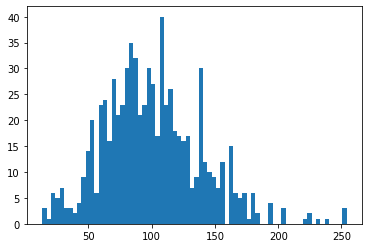

In [209]:
plt.hist(df.avg_salary, bins=70)
plt.show()

Похоже на нормальное. Лучший вариант для линейной регрессии :)

Закодируйте колонку `Job Description` при помощи **tf-idf**

*  попробуйте подобрать гиперпараметры `min_df`, `max_df`, `ngram_range` у метода для достижения наилучшего качества модели

In [250]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=4, max_df=0.95)
trX, teX, trY, teY = train_test_split(df['Job Description'], df["avg_salary"], test_size=0.2, random_state=RANDOM_STATE)
bow = tfidf.fit_transform(trX)
clf = Ridge(alpha=1.1)
clf.fit(bow, trY)
pred = clf.predict(tfidf.transform(teX))
print(r2_score(teY, pred))

0.6628627382427623


**Вопрос:** если использовать `min_df = 5`, `max_df=1.0`, `ngram_range=(1,1)`, то сколько столбцов получится в матрице после применения кодировки?

In [251]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df=5, max_df=1.0)
f = tfidf.fit_transform(df['Job Description'])
f.shape[1]

4640

Разобъем данные на тренировочные и тестовые. 

Здесь f - это матрица, полученная в результате кодирования столбца `Job Description`.

In [252]:
trX, teX, trY, teY = train_test_split(df['Job Description'], df["avg_salary"], test_size=0.2, random_state=RANDOM_STATE)

Обучите линейную регрессию под названием Ridge на тренировочных данных и сделайте предсказания на тренировочных и тестовых данных.

**model = Ridge(alpha=1.1)**

In [253]:
from sklearn.linear_model import Ridge

In [254]:
tfidf = TfidfVectorizer(ngram_range=(1, 1), min_df=5, max_df=1.0)
bow = tfidf.fit_transform(trX)
clf = Ridge(alpha=1.1)
clf.fit(bow, trY)

Ridge(alpha=1.1)

Посчитаем метрику качества предсказания $R^2$. Чем ближе она к 1, тем лучше качество модели.

Посчитайте значение $R^2$ на тренировочных и на тестовых данных.

**Вопрос:** чему равен $R^2$ на тесте? 

In [255]:
pred = clf.predict(tfidf.transform(teX))
print(r2_score(teY, pred))

0.6194641845147406


Потестируем нашу модель. Посмотрим. как она оценивает зарплаты :)

In [256]:
clf.predict(tfidf.transform([u"director"]))

array([94.60577841])

In [257]:
clf.predict(tfidf.transform([u"manager"]))

array([84.65346484])

**Вопрос:** посчитайте зарплату "data scientist" при помощи модели.

In [258]:
clf.predict(tfidf.transform([u"data scientist"]))

array([115.90779458])

Посмотрим на веса модели

**Вопрос:** какой признак имеет наибольший положительный вес?


In [259]:
%%time
coefs = sorted(zip(list(np.array(tfidf.get_feature_names())[clf.coef_ != 0]), clf.coef_[clf.coef_ != 0]),
               key=lambda x: -x[1])
coefs = pd.DataFrame(coefs, columns=["ngram", "weight"])

CPU times: user 16.5 ms, sys: 0 ns, total: 16.5 ms
Wall time: 17.8 ms


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [263]:
coefs.sort_values(by='weight')[-1:]

,ngram,weight
0,actuarial,37.239903
